# Optimization Setup + Visualization

In [1]:
# External libraries
import pandas as pd
import numpy as np
import pygad
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d
import umap
from matplotlib import cm

# Our classes
from optimization_pipeline.SIM import *
from optimization_pipeline.preprocessing import *

### Preprocess for True Strain

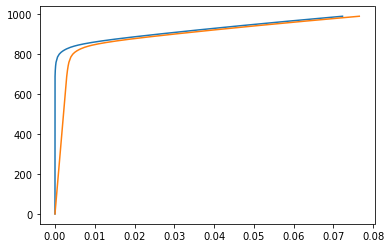

In [2]:
cp3 = pd.read_csv('CP_2.csv')
strain = cp3.iloc[:,1]
stress = cp3.iloc[:,0]
TPstrain = getTruePlasticStrain(strain, stress)
pd.DataFrame(dict(zip(('Stress MPa', 'True Plastic Strain'),(stress, TPstrain)))).to_csv('CP2_Demo.csv', index=False)
plt.plot(TPstrain, stress)
plt.plot(strain, stress)

### Plot Simulation

In [15]:
sims = np.load('simulations.npy', allow_pickle=True).item()
len(sims)

34

34


Text(0.5, 0, 'Strain')

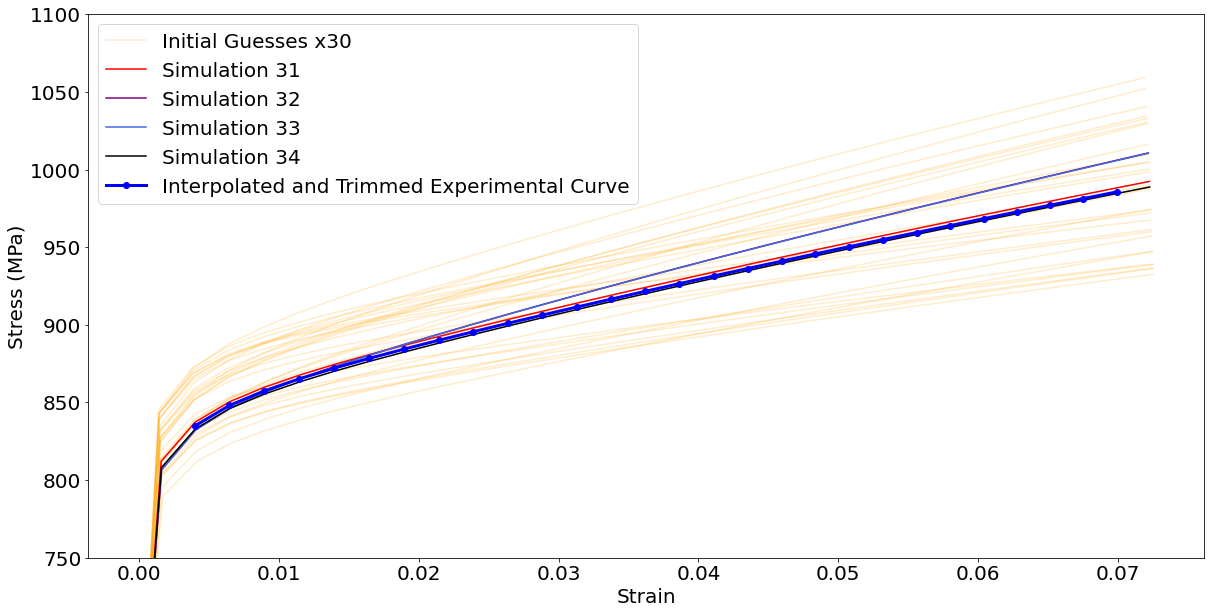

In [16]:
cp2 = pd.read_csv('CP2_Demo.csv')
exp_stress = cp2.iloc[:,0] # Take first column
exp_strain = cp2.iloc[:,1] # Take second column
f = interp1d(exp_strain, exp_stress)
x_min, x_max = 0.002, exp_strain.max()
sim_strain = np.array([strain for (strain,_) in sims.values()]).mean(axis=0)
prune = np.logical_and(sim_strain > x_min, sim_strain < x_max)
sim_strain = sim_strain[prune]
exp_target = f(sim_strain).reshape(1,len(sim_strain))
y = np.array([stress[prune] for (_, stress) in sims.values()])


plt.figure(figsize=(20,10))
plt.ylim([750,1100])
#sims = np.load('simulations_CP2.npy', allow_pickle=True).item()
print(len(sims))
for (strain, stress) in sims.values():
    plt.plot(strain, stress, c='orange', alpha=0.2, label="Initial Guesses x30")
colors = ['red', 'purple', 'royalblue', 'black', 'green']
i = 0
for key in list(sims.keys())[-4:]:
    plt.plot(*sims[key], c=colors[i], label=f"Simulation {30+i+1}")
    i += 1

#plt.plot(exp.iloc[:,1],exp.iloc[:,0], 'g-o', c='blue', label="Experimental Flow Curve")
plt.plot(sim_strain, exp_target.flatten(), 'g-o', linewidth=3, c='blue', label="Interpolated and Trimmed Experimental Curve")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={'size': 20})
plt.ylabel("Stress (MPa)", fontsize=20)
plt.xlabel("Strain", fontsize=20)

### Plot Fitness for 5 Curves

In [18]:
# D1 loss function: L2 loss 
plt.rc('font', size=20)          # controls default text sizes

def D1(exp_stress, sim_stress): 
    return np.sqrt(np.sum(np.square(exp_stress - sim_stress))/np.sum(np.square(exp_stress)))

def D2(exp_stress, sim_stress, strainobj): # Added strainobj as an input
    exp_stress_d1 = np.diff(exp_stress)/np.diff(strainobj)  
    sim_stress_d1 = np.diff(sim_stress)/np.diff(strainobj)
    return np.sqrt(np.sum(np.square(sim_stress_d1 - exp_stress_d1))/np.sum(np.square(exp_stress_d1)))

def D3(exp_stress, sim_stress):
    return np.max(np.sqrt(np.square(exp_stress - sim_stress)/sum(np.square(exp_stress))))

def D4(exp_stress, sim_stress, strainobj):
    exp_stress_d1 = np.diff(exp_stress)/np.diff(strainobj)
    sim_stress_d1 = np.diff(sim_stress)/np.diff(strainobj)
    return np.max(np.sqrt(np.square(sim_stress_d1 - exp_stress_d1)/np.sum(np.square(exp_stress_d1))))

def fitness(exp_stress, sim_stress,strainobj, w1, w2, w3, w4):
    return ( w1*D1(exp_stress, sim_stress) + w2*D2(exp_stress, sim_stress, strainobj) 
            + w3*D3(exp_stress, sim_stress) + w4*D4(exp_stress, sim_stress, strainobj))

# Testing on every index of sigma_hats
resD1 = []
resD2 = []
resD3 = []
resD4 = []
res_fit = []
w1 = 0.9
w2 = 0.005
w4 = 0.009
w3 = 1 - w1 - w2 - w4


labels = ['31st Simulation', '32nd Simulation', '33rd Simulation', '34th Simulation']

for sim_stress in y:
    resD1.append(D1(exp_target, sim_stress))
    resD2.append(D2(exp_target, sim_stress, sim_strain))
    resD3.append(D3(exp_target, sim_stress))
    resD4.append(D4(exp_target, sim_stress, sim_strain))
    res_fit.append(fitness(exp_target, sim_stress, sim_strain, w1, w2, w3, w4))

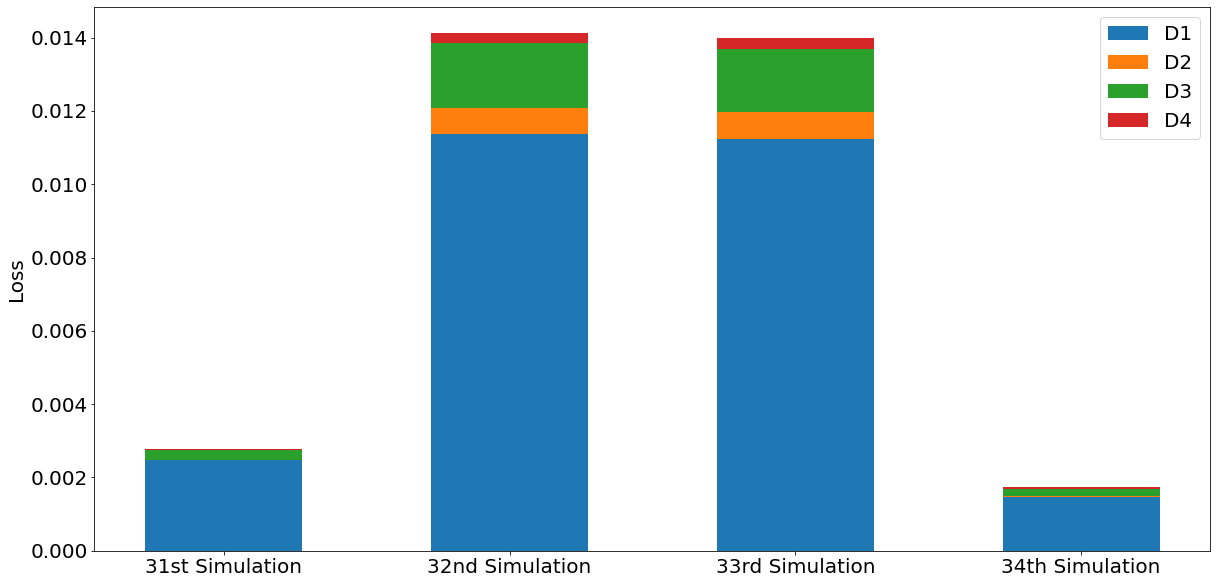

In [20]:
width = 0.55       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(20,10))
L1 = np.array(resD1)[-4:]*w1
L2 = np.array(resD2)[-4:]*w2
L3 = np.array(resD3)[-4:]*w3
L4 = np.array(resD4)[-4:]*w4

ax.bar(labels, L1, width, label='D1')
ax.bar(labels, L2, width, bottom=L1 , label='D2')
ax.bar(labels, L3, width, bottom=L1+L2, label='D3')
ax.bar(labels, L4, width, bottom=L1+L2+L3, label='D4')

#plt.hlines(res_fit[2], xmin=-0.55, xmax=4.55, linestyles='dashed')
ax.set_ylabel('Loss',size=20)
ax.legend(prop={'size': 20})
plt.show()

(1, 29)
(29,)


5.543320605006711

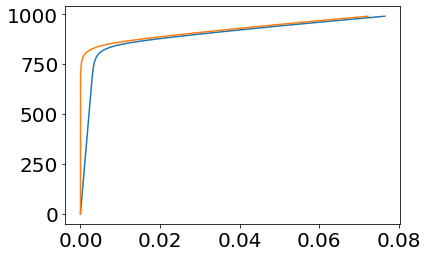

In [160]:
exp = pd.read_csv('sim_curve.csv')
strain = exp.iloc[:,1]
stress = exp.iloc[:,0]
plt.plot(strain,stress)
TPstrain = getTruePlasticStrain(strain, stress)
plt.plot(TPstrain, stress)
#pd.DataFrame(dict(zip(exp.columns,(stress, TPstrain)))).to_csv('CP2_Validation.csv', index=False)
exp_stress = exp["True stress, MPa"]
exp_strain = TPstrain #exp["True strain, -"]
f = interp1d(exp_strain, exp_stress)
x_min, x_max = 0.002, exp_strain.max()
sim_strain = np.array([strain for (strain,_) in sims.values()]).mean(axis=0)
prune = np.logical_and(sim_strain > x_min, sim_strain < x_max)
sim_strain = sim_strain[prune]
exp_target = f(sim_strain).reshape(1,len(sim_strain))
y = np.array([stress[prune] for (_, stress) in sims.values()])
print(exp_target.shape)
print(y[-1].shape)
mean_squared_error(y[-1].reshape((1,-1)), exp_target)

Text(0, 0.5, 'Fitness Value')

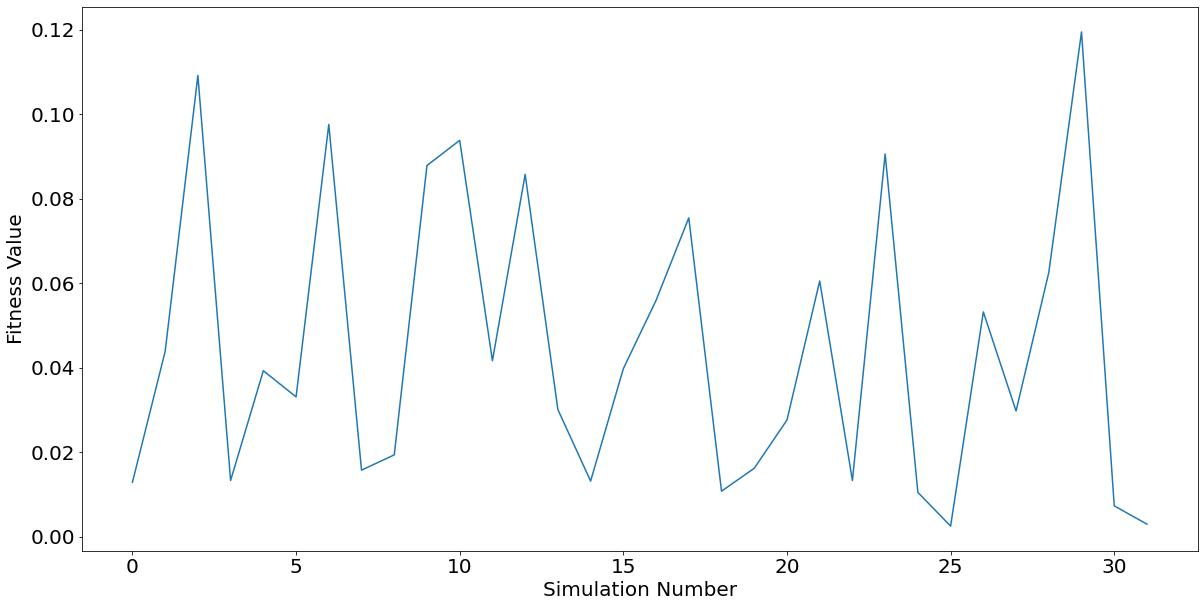

In [172]:
plt.figure(figsize=(20,10))
plt.plot(res_fit)
plt.xlabel("Simulation Number")
plt.ylabel("Fitness Value")

ValueError: shape mismatch: objects cannot be broadcast to a single shape

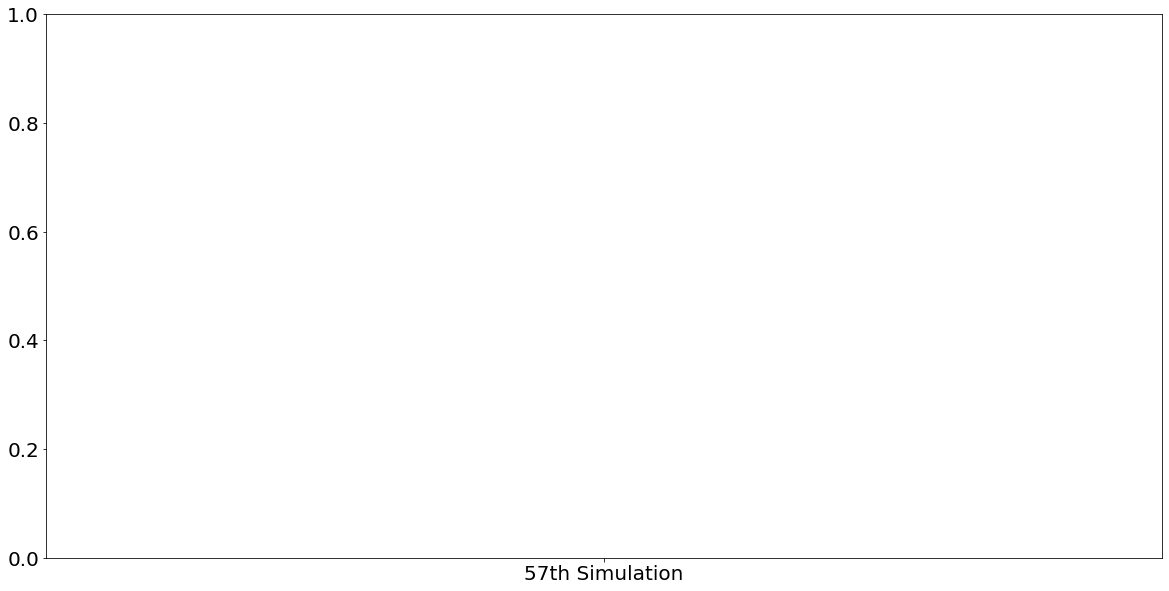

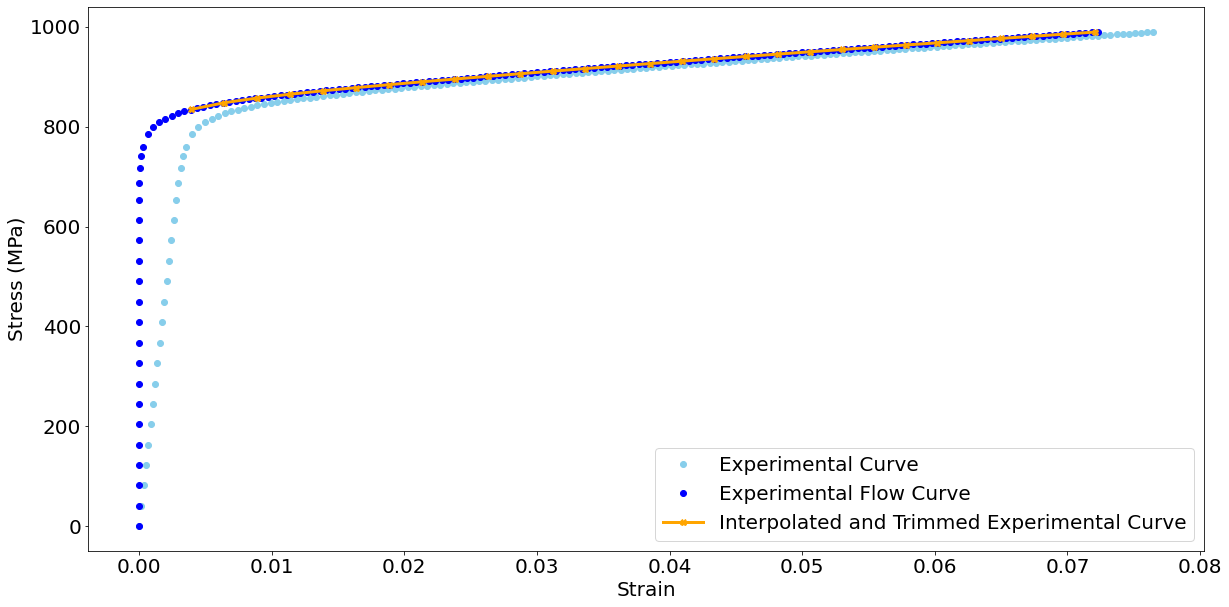

In [180]:
exp = pd.read_csv("sim_curve.csv")
exp_stress = exp["True stress, MPa"]
exp_strain = exp["True strain, -"]
plt.figure(figsize=(20,10))
plt.plot(exp_strain, exp_stress, 'o', c='skyblue', label="Experimental Curve")
plt.plot(TPstrain, exp_stress, 'o', c='blue', label="Experimental Flow Curve")
plt.plot(sim_strain, exp_target.flatten(), 'g-X', linewidth=3, c='orange', label="Interpolated and Trimmed Experimental Curve")
plt.ylabel("Stress (MPa)", fontsize=20)
plt.xlabel("Strain", fontsize=20)
plt.legend(prop={'size': 20})

In [289]:
X = []
y = []
for (k, v) in sims.items():
    X.append(k)
    y.append(v[1])
X = np.array(X)
y = np.array(y)

In [290]:
# Save a single output to be used as ytest, to test if we can converge to it.
for _ in range(5):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=32/33, shuffle=True)
    mlp = MLPRegressor(hidden_layer_sizes=[15], solver='adam', max_iter=100000, max_fun=150000, shuffle=True)
    mlp.fit(Xtrain, ytrain)
    y_pred = mlp.predict(Xtest)
    print('MSE: ', mean_squared_error(y_pred, ytest))

MSE:  3.285759801325977
MSE:  33.6471470991401
MSE:  10.50800508527589
MSE:  6.781575989270492
MSE:  3.338786396596882


In [291]:
# Save a single output to be used as ytest, to test if we can converge to it.
for _ in range(5):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=32/33, shuffle=True)
    mlp = MLPRegressor(hidden_layer_sizes=[15], solver='adam', activation='logistic', max_iter=100000, max_fun=150000, shuffle=True)
    mlp.fit(Xtrain, ytrain)
    y_pred = mlp.predict(Xtest)
    print('MSE: ', mean_squared_error(y_pred, ytest))

MSE:  149.7005046086285
MSE:  323.818259401235
MSE:  236.00495845398217
MSE:  281.77332244791336
MSE:  787.4555841714568


In [107]:
tau_step = 10
tau = (100,120+tau_step)
taucs_step = 10
taucs = (220,250+taucs_step)
h0_step = 100
h0 = (600,800+h0_step)
alpha_step = 1
alpha = (3,5+alpha_step)

opt_grid = np.mgrid[tau[0]:tau[1]:tau_step,
                    taucs[0]:taucs[1]:taucs_step,
                    h0[0]:h0[1]:h0_step,
                    alpha[0]:alpha[1]:alpha_step]
np.vstack([xi.ravel() for xi in opt_grid]).T.shape

(108, 4)

In [73]:
prune = [True, True, False]
a = np.array([1,2,3]).reshape(1,3)
a1 = np.array([2, 4]).reshape(1,2)
print(a1.shape)
ap = a[:,prune]
mean_squared_error(ap,a1)

(1, 2)


2.5

In [239]:
points = []
for _ in range(5):
    tau = np.random.randint(low=100, high=120)
    taucs = np.random.randint(low=220, high=250)
    h0 = np.random.randint(low=600, high=800)
    alpha = np.random.randint(low=2, high=5)
    points.append(np.array((tau, taucs, h0,alpha)))
np.array(points).mean(axis=0).round(decimals=3)

array([111. , 236.6, 673.2,   3. ])

In [ ]:
points = []
point = (0,0,0,0)
for p in range(4):
points

In [181]:
flow = pd.read_csv('./flowcurves/simulations.csv', header=None)
strains = flow.iloc[4,:].str.replace('[', '').replace(']', '').replace('\n', '').str.split(' ', expand=True).astype(float)
#stresses = flow.iloc[5,:].str.split(' ', expand=True)
strains

<ipython-input-181-f3795d8fa7ae>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  strains = flow.iloc[4,:].str.replace('[', '').replace(']', '').replace('\n', '').str.split(' ', expand=True).astype(float)


ValueError: could not convert string to float: ''

In [143]:
exp = pd.read_csv('exp_curve.csv')
exp

,"True stress, MPa","True strain, -",Simulated strain
0,1.600000e-12,0.000000,-6.815842e-18
1,4.069159e+01,0.000173,-6.803369e-18
2,8.141870e+01,0.000346,-1.636737e-07
3,1.221813e+02,0.000519,-4.911007e-07
4,1.629656e+02,0.000693,-7.919114e-07
...,...,...,...
168,3.875211e+02,0.075037,NaN
169,3.881409e+02,0.075501,NaN
170,3.887579e+02,0.075966,NaN
171,3.893723e+02,0.076430,NaN


In [79]:
a = {1:(np.array([1,2]),np.array([1,2])),2:(np.array([2,3]),np.array([2,3]))}
pd.DataFrame.from_dict(a).to_csv('a.csv')

In [204]:
dirs = [f'./simulations/{i}' for i in range(1,18)]
sim = SIM()
params = sim.get_grid() + [(119, 249, 750,  3)]
d2p = dict(zip(dirs, params))
sim.filename2params = d2p
sim.save_outputs()

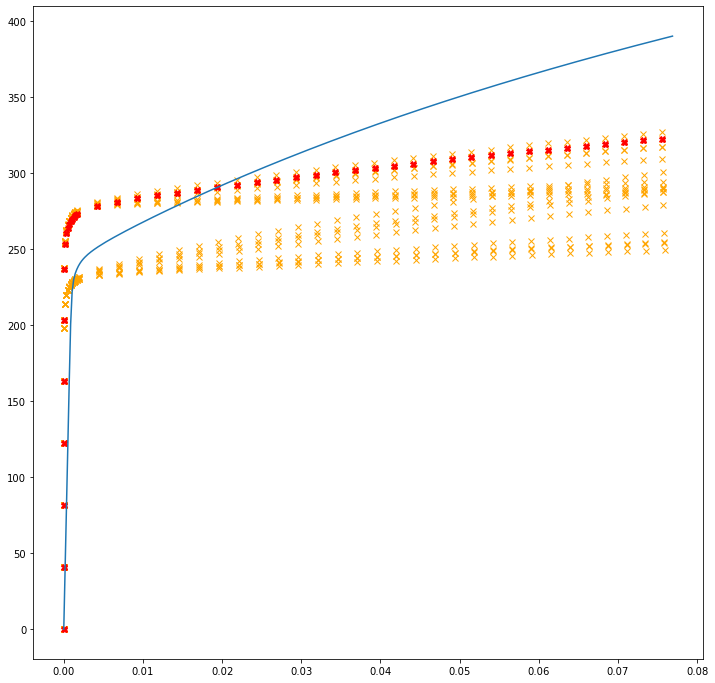

In [227]:
plt.figure(figsize=(12,12))
all_sim = list(sim.simulations.values())
s = [plt.plot(strain, stress, 'x', c='orange') for (strain,stress) in all_sim[0:17]]
plt.plot(all_sim[-1][0], all_sim[-1][1], 'X', c='red')
key = list(sim.simulations.keys())
plt.plot(exp.iloc[:,1],exp.iloc[:,0])

In [60]:
df1 = pd.DataFrame({'Simulated strain':np.mean(s, axis=0)})
pd.concat([exp,df1], axis=1).to_csv('exp_curve_1.csv', index=False)

In [48]:
sim = SIM()
filenames = []
sim.get_grid()
for i in range(1,17):
    filenames.append(f'./simulations/{i}')
sim.filename2params = dict(zip(filenames, sim.get_grid()))
sim.save_outputs()

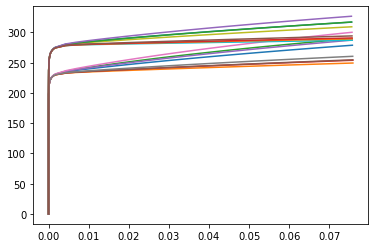

In [50]:
for v in sim.simulations.values():
    plt.plot(*v)

In [100]:
# 3. Initalize and fit response surface
sim_strain = np.array(list(sim.simulations.values())[0][0])
y = np.array([stress for (_, stress) in sim.simulations.values()])
X = np.array(list(sim.simulations.keys()))
n = len(y)

exp = pd.read_csv('exp_curve.csv')
exp_stress = exp["True stress, MPa"]
exp_strain = exp["True strain, -"]
f = interp1d(exp_strain, exp_stress)
x_min, x_max = 0.002, exp_strain.max()
prune = np.logical_and(sim_strain > x_min, sim_strain < x_max)
sim_strain = sim_strain[prune]
exp_target = f(sim_strain).reshape(1,len(sim_strain))


# Save a single output to be used as ytest, to test if we can converge to it.
#Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=15/16, shuffle=True)
mlp = MLPRegressor(hidden_layer_sizes=[15,30], solver='adam', max_iter=100000, max_fun=150000, shuffle=True)
mlp.fit(X, y)
#y_pred = mlp.predict(Xtest)
#print('MSE: ', mean_squared_error(y_pred, ytest))

# 4. Fitness function
def fitness(solution, solution_idx):
    sol = solution.reshape((1,4))
    y_pred = mlp.predict(sol)
    fitness = mean_squared_error(y_pred[:,prune], exp_target)
    return fitness

In [101]:
reducer = umap.UMAP()
X2D = reducer.fit_transform(X)
x1, x2 = np.meshgrid(X2D[:,0], X2D[:,1])
Z = np.array([fitness(sol,0) for sol in X]).reshape(1,-1)

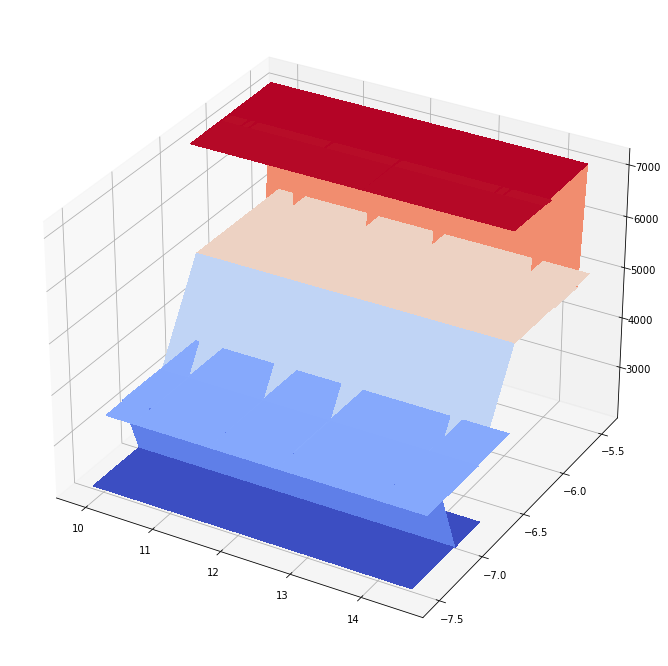

In [102]:
fig, ax = plt.subplots(figsize=(12,12), subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x2,x1, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

### 1.2 Optimize on response surface

In [18]:
# Initialize Optimizer
num_generations = 50 # Number of generations.
num_parents_mating = 250 # Number of solutions to be selected as parents in the mating pool.
sol_per_pop = 500 # Number of solutions in the population.
num_genes = 4
gene_space = [
    {'low': 100, 'high': 120, 'step': 1},  # tau
    {'low': 230, 'high': 250, 'step': 1},  # taucs
    {'low': 600, 'high': 800, 'step': 50}, # h0
    {'low': 3, 'high': 5, 'step': 1}]      # alpha
last_fitness = 0
keep_parents = 1
crossover_type = "single_point"
mutation_type = "random"
mutation_percent_genes = 25

def on_generation(ga_instance):
    global last_fitness
    generation = ga_instance.generations_completed
    fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]
    change = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness
    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]

# Running the GA Optimization to optimize the parameters of the function.
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       fitness_func=fitness,
                       on_generation=on_generation,
                       gene_space=gene_space,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes)
ga_instance.run()

### 1.3 Evaluate Optimization

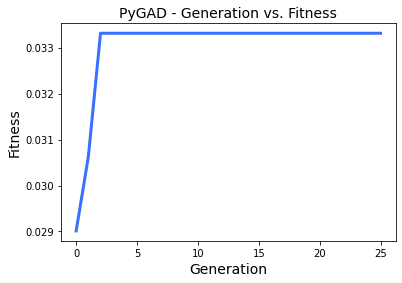

Parameters of the best solution : [118. 238. 600.   4.]
Real solution parameters: [120 230 600   5]
Fitness value of the best solution = 0.033311293060607115
Index of the best solution : 0
MSE of the best solution : 30.019849370019454
Best fitness value reached after 2 generations.


In [19]:
ga_instance.plot_fitness()

def output_results(ga_instance):
    # Returning the details of the best solution in a dictionary.
    solution, solution_fitness, solution_idx = ga_instance.best_solution(ga_instance.last_generation_fitness)
    best_solution_generation = ga_instance.best_solution_generation
    prediction = mlp.predict(solution.reshape((1,4)))
    loss = mean_squared_error(prediction, ytest)
    values = (solution, solution_fitness, solution_idx, best_solution_generation, prediction, loss)
    keys = ("solution", "solution_fitness", "solution_idx", "best_solution_generation", "prediction", "loss")
    output = dict(zip(keys, values))
    return output

def print_results(results):
    print(f"Parameters of the best solution : {results['solution']}")
    print(f"Real solution parameters: {Xtest[0]}") # To be removed after testing
    print(f"Fitness value of the best solution = {results['solution_fitness']}")
    print(f"Index of the best solution : {results['solution_idx']}")
    print(f"MSE of the best solution : {results['loss']}")
    print(f"Best fitness value reached after {results['best_solution_generation']} generations.")
    
results = output_results(ga_instance)
loss = results['loss']
print_results(results)

## 2. Iterative Process

In [ ]:
while loss > epsilon:
    (true_strain, stress) = sim.run_single_test(solution)
    mlp.partial_fit(np.array(solution), stress)
    ga_instance.run()
    results = output_results(ga_instance)
    print_results(results)
    loss = results["loss"]

print("--------------------")
print("Final Parameters: ", results['solution'])
print("--------------------")